In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

In [2]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

In [3]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 3. Base Line

In [4]:
import pickle
with open('raw_data_20180811.pickle','rb') as handle:

    raw_data = pickle.load(handle)

In [5]:
kospi200 = pd.read_excel("C:\\Users\\axasd\\Downloads\\상장법인목록.xlsx")
kospi200 = kospi200[kospi200.columns[:2]]
kospi200["종목코드"] = kospi200["종목코드"].map('{:06d}'.format)

In [6]:
code_dict = {
    i : j for i, j in zip(kospi200["회사명"], kospi200["종목코드"])
}

In [7]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(sum_close_3 = raw_data[i].Close.rolling(window = 3).sum())
    raw_data[i] = raw_data[i].assign(sum_close_5 = raw_data[i].Close.rolling(window =5).sum())
    raw_data[i] = raw_data[i].assign(ma_5 = raw_data[i].Close.rolling(window = 5).mean())
    raw_data[i] = raw_data[i].assign(ma_10 = raw_data[i].Close.rolling(window = 10).mean())

In [8]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change = raw_data[i].Close.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(Y = np.where(raw_data[i]["pct_change"].fillna(0)>=0, 1,0))

In [9]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].assign(pct_change2 = raw_data[i].sum_close_3.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(pct_change3 = raw_data[i].sum_close_5.pct_change().fillna(0))
    raw_data[i] = raw_data[i].assign(sencond_Y = np.where(raw_data[i]["pct_change2"].fillna(0)>=0, 1,0))
    raw_data[i] = raw_data[i].assign(third_Y = np.where(raw_data[i]["pct_change3"].fillna(0)>=0, 1,0))

In [10]:
copy_keys = kospi200["종목코드"]

In [11]:
for i in raw_data.keys():
    raw_data[i] = raw_data[i].dropna(axis=0)

In [12]:
for i in copy_keys:
    if (len(raw_data[i]) < 252):
        del raw_data[i]

In [13]:
len(raw_data)

197

In [14]:
raw_data[code_dict["AK홀딩스"]].head(6)

,Open,High,Low,Close,Adj Close,Volume,sum_close_3,sum_close_5,ma_5,ma_10,pct_change,Y,pct_change2,pct_change3,sencond_Y,third_Y
Date,,,,,,,,,,,,,,,,
2012-01-13,14030.599609,14362.299805,13816.000000,14069.599609,13455.370117,169798,41701.500000,70172.500000,14034.500000,14508.690039,0.015489,1,0.001405,-0.004981,1,0
2012-01-16,13894.000000,14206.200195,13601.299805,13640.299805,13044.811523,137642,41564.899414,69352.899414,13870.579883,14389.650000,-0.030513,0,-0.003276,-0.011680,0,0
2012-01-17,13776.900391,13913.500000,13328.099609,13464.700195,12876.877930,209890,41174.599609,68806.500000,13761.300000,14202.320020,-0.012874,0,-0.009390,-0.007879,0,0
2012-01-18,13542.799805,13816.000000,13269.599609,13698.900391,13100.853516,214079,40803.900391,68728.500000,13745.700000,14044.260059,0.017394,1,-0.009003,-0.001134,0,0
2012-01-19,13913.500000,14206.200195,13737.900391,14011.099609,13399.422852,201378,41174.700195,68884.599609,13776.919922,13940.840039,0.022790,1,0.009087,0.002271,1,1
2012-01-20,14128.200195,14128.200195,13620.799805,13855.000000,13250.137695,153356,41565.000000,68670.000000,13734.000000,13884.250000,-0.011141,0,0.009479,-0.003115,1,0


### Train, Test Split

In [15]:
train = {}
train_idx = {}
test = {}
test_idx = {}
for code, df in raw_data.items():
    train[code] = df.iloc[:int(len(df)*0.8)][["Open","ma_5", "ma_10"]]
    train_idx[code] = df.iloc[:int(len(df)*0.8)]["Y"]
    test[code] = df.iloc[int(len(df)*0.8):][["Open","ma_5", "ma_10"]]
    test_idx[code] = df.iloc[int(len(df)*0.8):]["Y"]

### Scale 조정

In [16]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
li = ["Open","ma_5", "ma_10"]
for code in raw_data.keys():
    train[code][li] = std_scaler.fit_transform(train[code][li].values)
    test[code][li] = std_scaler.fit_transform(test[code][li].values)

### model 호출

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

log_clf = LogisticRegression()
DTC_clf = DecisionTreeClassifier()
svm_clf = SVC()

### Predict

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
score_list = pd.DataFrame(columns=('LR','DT','SVM'))
CM = pd.DataFrame(columns=('LR','DT','SVM'))
roc_auc_score = pd.DataFrame(columns=('LR','DT','SVM'))

for i in raw_data.keys():
    a=[]
    a1=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    X_test = test[i].values
    y_test = test_idx[i].values
    for clf in (log_clf, DTC_clf, svm_clf):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        a.append(accuracy_score(y_test, y_pred))
        y_train_pred = cross_val_predict(clf, X_train, y_train, cv=3)
        a1.append([confusion_matrix(y_train, y_train_pred)])
    score_list.loc[i] = a
    CM.loc[i] = a1

In [45]:
roc_auc_score = pd.DataFrame(columns=('LR','SVM'))

for i in raw_data.keys():
    a2=[]
    X_train = train[i].values
    y_train = train_idx[i].values
    score=cross_val_predict(log_clf, X_train, y_train, cv=3,method="decision_function")
    fpr, tpr, thresholds = roc_curve(y_train, score)
    a2.append([auc(fpr, tpr)])
    
    score=cross_val_predict(svm_clf, X_train, y_train, cv=3,method="decision_function")
    fpr, tpr, thresholds = roc_curve(y_train, score)
    a2.append([auc(fpr, tpr)])
    roc_auc_score.loc[i] = a2

(array([ 1.,  0.,  0.,  0.,  1., 15., 59., 74., 38.,  9.]),
 array([0.28173375, 0.31764706, 0.35356037, 0.38947368, 0.425387  ,
        0.46130031, 0.49721362, 0.53312693, 0.56904025, 0.60495356,
        0.64086687]),
 <a list of 10 Patch objects>)

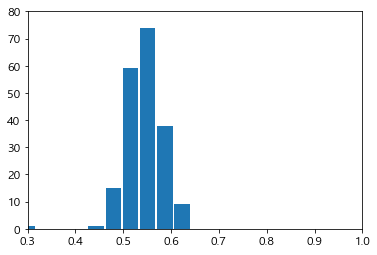

In [46]:
plt.axis([0.3,1,0,80])
plt.hist(score_list['LR'],bins=10,rwidth=0.9)

In [47]:
score_list.describe()

,LR,DT,SVM
count,197.000000,197.000000,197.000000
mean,0.542237,0.515668,0.522092
std,0.039423,0.033360,0.033162
min,0.281734,0.411765,0.445820
25%,0.517028,0.492260,0.501548
50%,0.541796,0.517028,0.520124
75%,0.563467,0.535604,0.541796
max,0.640867,0.693498,0.699690


In [48]:
roc_auc_score

,LR,SVM
006840,[0.5180697551293736],[0.4814467408200712]
027410,[0.5392617286353903],[0.4466310589838427]
138930,[0.47125193835018275],[0.4521018852496692]
001040,[0.5275561046012663],[0.5095697539206134]
079160,[0.5209076841239905],[0.4903767106726631]
000120,[0.541116208395033],[0.51385219167078]
097950,[0.5712141721378126],[0.5170069996887419]
005830,[0.5282061703038704],[0.500453592086451]
000990,[0.5070456513819899],[0.48494249851029286]
114090,[0.5517840593141797],[0.5097408866234168]


In [49]:
CM.loc["006840"]['LR']

[array([[129, 482],
        [143, 534]], dtype=int64)]

In [50]:
CM.loc["006840"]['DT']

[array([[218, 393],
        [233, 444]], dtype=int64)]

In [51]:
CM.loc["006840"]['SVM']

[array([[ 97, 514],
        [144, 533]], dtype=int64)]